# Task 4

Датасет русскоязычных отзывов на аниме. 3 класса: нейтральный, положительный и отрицательный.

1. Требуется качественная обработка данных + feature engineering.

2. Сравнить случайный лес и бустинг для сентимент анализа.

3. Отобразить ключевые слова для решения классификаторов.

4. Отрисовать рисунки обученных деревьев из случайного леса и бустинга с указанием текста, влияющего на ветвление дерева.

5. Выложить на github

## Imports

In [2]:
!pip install emoji --upgrade

In [3]:
!pip install pymorphy3

In [445]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import re
import emoji
from nltk import word_tokenize, sent_tokenize, download
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import unicodedata
import html
from nltk import pos_tag

download('punkt')
download('stopwords')
stop_words = stopwords.words('russian')

import pymorphy3
morph = pymorphy3.MorphAnalyzer()
from sklearn.preprocessing import LabelEncoder
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
import gensim
import json
from scipy.sparse import hstack

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Анализ датасета

**Объединяю все датасеты в один**

In [20]:
df1 = pd.read_excel('dataset1.xlsx')
df2 = pd.read_excel('dataset2.xlsx')
df3 = pd.read_excel('dataset3.xlsx')
df4 = pd.read_excel('dataset4.xlsx')

In [21]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [22]:
df

,Anime,Rate,Text
0,Нежный укус / Amagami SS,Нейтральный,"после первой арки несколько разочаровался, ожи..."
1,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Концовка какая-то мутная, ничего не понял. Над..."
2,Мобильный воин Гандам: Единорог / Kidou Senshi...,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х..."
3,Невиданный цветок / Ano Hi Mita Hana no Namae ...,Положительный,Только что досмотрел и меня переполняют эмоции...
4,Принцесса-медуза / Kuragehime,Положительный,"И правда не оторваться. Но, по-моему, то, что ..."
...,...,...,...
73211,Пожиратель звёзд / Tunshi Xingkong,Положительный,Я просмотрел 82 серии Пожирателя звёзд (Swallo...
73212,Пожиратель звёзд 2 / Tunshi Xingkong 2nd Season,Положительный,Я был сильно заинтригован аниме Поглощающая Зв...
73213,Повелитель 2 / Overlord II,Нейтральный,докатились. после просмотра этого чуда я добав...
73214,Ангел по соседству / Otonari no Tenshi-sama ni...,Положительный,Вокруг этого произведения собралось достаточно...


**Удаляю повторы и пустые строки**

In [28]:
df = df.drop_duplicates(subset=['Text'])

len(df)

73166

In [30]:
missing_values = df.isnull().sum()
missing_values

Anime    0
Rate     0
Text     1
dtype: int64

In [32]:
df = df.dropna(subset=["Text"])

len(df)

73165

Я заметила, что одни и те же слова, специфичные для этого датасета, могут писаться по-разному, например, 'фентези' вместо 'фэнтези' и т.д. Составляю словарик, чтобы после лемматизации привести слова к одной форме

In [34]:
variations = {
    'фэнтези': ['фентези'],
    'хентай': ['хэнтай'],
    'аниме': ['анимэ', 'анеме', 'анемэ', 'ониме', 'онимэ'],
    'новелла': ['новэлла', 'новела'],
    'сёнен': ['шёнен', 'сёнэн'],
    'исэкай': ['исекай'],
    'трэш': ['треш'],
    'саске': ['саскэ'],
    'кагоме': ['кагомэ'],
    'супергерой': ['супер герой'],
    'семпай': ['сэмпай'],
    'кун': ['kun'],
    'чиби': ['чибби'],
    'ня': ['мя'],
    'гарем': ['гаремник', 'harem'],
    'сёдзё': ['сёдзе'],
    'ничего': ['ниче'],
    'сеттинг': ['сэттинг'],
    'персонаж': ['перс'],
    'клиффхэнгер': ['клиффхенгер'],
    'сёнен': ['шонен'],
    'сэйнэн': ['сейнен'],
    'сёдзё': ['седзе'],
    'исэкай': ['исекай'],
    'фан-сервис': ['фансервис'], 
    'анимешный': ['анимэшный'], 
}

**Заменяю смайлики на их текстовые описания на русском языке**

In [36]:
def emojis_to_text(text):
    return emoji.demojize(text, language='ru')

tqdm.pandas()
df['Text_Converted'] = df['Text'].progress_apply(emojis_to_text)

100%|███████████████████████████████████| 73165/73165 [00:30<00:00, 2361.81it/s]


In [37]:
for i in df['Text_Converted']:
    if ':широко_улыбается:' in i:
        print(i)
        break

Мда,смотрю тут прям эксперты выше легендарного ранга,или видимо я чего-то не понимаю в аниме. :широко_улыбается:"Ах,смотрибельно", "Ах, Субару тупой и трусливый" , "Г*вно,аниме, ни о чем" .  "Сначала первой серии понятно что ни то,ни  се". Народ походу дела зажрался.Аниме классное, да не отрицаю по началу Субару показывается трусом, но потом с каждой серией становится лучше. Я сначала первой серии затаив дыхание следила за героями,каждое мгновение переживая за них, смеялась в некоторых местах. И первая серия очень интересная,мне понравилось. Люди ,че вы прям анализируете каждое аниме, как будто психологи разбирающие шизофреника на консилиуме. Будьте проще, включили аниме и отдайтесь чувствам,расслабьтесь и наслаждайтесь каждой просмотренной минутой.


**Заменяю эмотиконы на их текстовые описания на русском языке**

In [38]:
with open('emoticons.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [39]:
d = {}
for key, value in data.items():
    d[key] = list(value.values())[0]

In [40]:
for i in df['Text']:
    if '^_^' in i:
        print(i)
        break

В целом понравилось, так как тема зомби в общем то интересна. Но слишком уж много фансервиса... Я понимаю что сиськи это хорошо... но блин когда она бежит с мечем и крушит зомби и тут же... Вернее Бегут сиськи а потом уже она бежит за ними... Короче могло что то более интересное получиться в плане темы зомби-апокалипсиса но увы... Хотя сиськи тоже хорошо но их и так кругом полно ^_^


In [41]:
def remove_emoticons(text):
    text = text.lower()
    
    def replace_emoticon(match):
        emoticon = match.group(0)
        return d.get(emoticon, emoticon)
    
    emoticon_pattern = re.compile('|'.join(re.escape(key) for key in d.keys()))
    result = emoticon_pattern.sub(replace_emoticon, text)
    
    return result

In [42]:
df['Text_Converted'] = df['Text_Converted'].progress_apply(remove_emoticons)

100%|███████████████████████████████████| 73165/73165 [00:12<00:00, 5802.26it/s]


In [43]:
for i in df['Text_Converted']:
    if '^_^' in i:
        print(i)

**Разделение слов по заглавной букве, пробелу и нижнему подчеркиванию**

In [54]:
def split_text(text):
    text = re.sub(r'([a-zа-яё])([A-ZА-ЯЁ])', r'\1 \2', text)
    text = re.sub(r'[-_]', ' ', text)
    return text

In [56]:
tqdm.pandas()
df['Text_Converted'] = df['Text_Converted'].progress_apply(split_text)

100%|██████████████████████████████████| 73165/73165 [00:01<00:00, 38496.87it/s]


**Проверяю, как часто в отзывах встречаются слова, в которых символы повторяются 3 и более раз подряд**

In [79]:
def has_repeated(word):
    pattern = re.compile(r'(.)\1{2,}')  
    return pattern.search(word) is not None

def find_words(text):
    words = re.findall(r'\b\w+\b', text) 
    repeated_words = [word for word in words if has_repeated(word)]
    return repeated_words

unique_repeated = set([word for sublist in df['Text_Converted'].apply(lambda x: find_words(x)).tolist() for word in sublist])

print(len(unique_repeated))

3123


In [80]:
list(unique_repeated)[:10]

['нооочь',
 'коваааарная',
 'ііі',
 'хааа',
 'иссскуств',
 'ыыыыауауэааээээ',
 'понимааать',
 'знаееееет',
 'безнадёёёга',
 'реееедкими']

**Ищу слова на на русском языке**

In [84]:
pattern = r'([a-zA-Z\s,、]+)' 
eng = df['Text_Converted'].str.extract(pattern)
eng = eng.dropna()
eng = eng.drop_duplicates()

In [86]:
eng_words = [_ for _ in eng[0] if i[0].isalpha()]
eng_words[:20]

[' ',
 'holy diver, ',
 'morr',
 ', ',
 ' black lagoon',
 'happy gear, ',
 'makura no soushi ',
 'anna k, ',
 'rina ',
 'strager, ',
 'nikitkaz, ',
 'exzarcist',
 'index',
 'yuki, ',
 'daiver',
 'miig, ',
 'silicium',
 'yoshimoto motochika, ',
 'rini, ',
 '   ']

В целом кажется, что английские слова не вносят значимого вклада в анализ сентимента, поэтому для упрощения анализа я удалю их во время предпроцессинга

**Выполняю минимальную предобработку, чтобы затем расширить список стоп-слов на основе самых частотных и излишне редких**

In [74]:
def preprocess(text):
    text = re.sub(r'[^а-яё]', ' ', text, flags=re.IGNORECASE).lower()
    tokens = word_tokenize(text)

    lemmas = [morph.parse(token)[0].normal_form for token in tokens]

    tokens = [lemma for lemma in lemmas if lemma.strip() and lemma not in stop_words]
    
    return tokens

In [76]:
df['tokens'] = df['Text_Converted'].progress_apply(preprocess)

100%|█████████████████████████████████████| 73165/73165 [14:03<00:00, 86.70it/s]


In [77]:
df

,Anime,Rate,Text,Text_Converted,tokens
0,Нежный укус / Amagami SS,Нейтральный,"после первой арки несколько разочаровался, ожи...","после первой арки несколько разочаровался, ожи...","[первый, арка, несколько, разочароваться, ожид..."
1,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Концовка какая-то мутная, ничего не понял. Над...","концовка какая то мутная, ничего не понял. над...","[концовка, мутный, понять, надеяться, второй, ..."
2,Мобильный воин Гандам: Единорог / Kidou Senshi...,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х...","что тут сказать? никакого сравнени я с seed, х...","[сказать, никакой, сравненить, пытаться, подра..."
3,Невиданный цветок / Ano Hi Mita Hana no Namae ...,Положительный,Только что досмотрел и меня переполняют эмоции...,только что досмотрел и меня переполняют эмоции...,"[досмотреть, переполнять, эмоция, шедевр, затя..."
4,Принцесса-медуза / Kuragehime,Положительный,"И правда не оторваться. Но, по-моему, то, что ...","и правда не оторваться. но, по моему, то, что ...","[правда, оторваться, медуза, серия, езмъ, плюс..."
...,...,...,...,...,...
73211,Пожиратель звёзд / Tunshi Xingkong,Положительный,Я просмотрел 82 серии Пожирателя звёзд (Swallo...,я просмотрел 82 серии пожирателя звёзд (swallo...,"[просмотреть, серия, пожиратель, звезда, день,..."
73212,Пожиратель звёзд 2 / Tunshi Xingkong 2nd Season,Положительный,Я был сильно заинтригован аниме Поглощающая Зв...,я был сильно заинтригован аниме поглощающая зв...,"[сильно, заинтриговать, аниме, поглощать, звез..."
73213,Повелитель 2 / Overlord II,Нейтральный,докатились. после просмотра этого чуда я добав...,докатились. после просмотра этого чуда я добав...,"[докатиться, просмотр, это, чудо, добавить, из..."
73214,Ангел по соседству / Otonari no Tenshi-sama ni...,Положительный,Вокруг этого произведения собралось достаточно...,вокруг этого произведения собралось достаточно...,"[вокруг, это, произведение, собраться, достато..."


In [96]:
df.to_csv('anime_tokens.csv', index=False)

In [6]:
df = pd.read_csv('anime_tokens.csv')

In [7]:
df

,Anime,Rate,Text,Text_Converted,tokens
0,Нежный укус / Amagami SS,Нейтральный,"после первой арки несколько разочаровался, ожи...","после первой арки несколько разочаровался, ожи...","['первый', 'арка', 'несколько', 'разочароватьс..."
1,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Концовка какая-то мутная, ничего не понял. Над...","концовка какая то мутная, ничего не понял. над...","['концовка', 'мутный', 'понять', 'надеяться', ..."
2,Мобильный воин Гандам: Единорог / Kidou Senshi...,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х...","что тут сказать? никакого сравнени я с seed, х...","['сказать', 'никакой', 'сравненить', 'пытаться..."
3,Невиданный цветок / Ano Hi Mita Hana no Namae ...,Положительный,Только что досмотрел и меня переполняют эмоции...,только что досмотрел и меня переполняют эмоции...,"['досмотреть', 'переполнять', 'эмоция', 'шедев..."
4,Принцесса-медуза / Kuragehime,Положительный,"И правда не оторваться. Но, по-моему, то, что ...","и правда не оторваться. но, по моему, то, что ...","['правда', 'оторваться', 'медуза', 'серия', 'е..."
...,...,...,...,...,...
73160,Пожиратель звёзд / Tunshi Xingkong,Положительный,Я просмотрел 82 серии Пожирателя звёзд (Swallo...,я просмотрел 82 серии пожирателя звёзд (swallo...,"['просмотреть', 'серия', 'пожиратель', 'звезда..."
73161,Пожиратель звёзд 2 / Tunshi Xingkong 2nd Season,Положительный,Я был сильно заинтригован аниме Поглощающая Зв...,я был сильно заинтригован аниме поглощающая зв...,"['сильно', 'заинтриговать', 'аниме', 'поглощат..."
73162,Повелитель 2 / Overlord II,Нейтральный,докатились. после просмотра этого чуда я добав...,докатились. после просмотра этого чуда я добав...,"['докатиться', 'просмотр', 'это', 'чудо', 'доб..."
73163,Ангел по соседству / Otonari no Tenshi-sama ni...,Положительный,Вокруг этого произведения собралось достаточно...,вокруг этого произведения собралось достаточно...,"['вокруг', 'это', 'произведение', 'собраться',..."


In [80]:
for i in df['tokens']:
    print(i)
    break

['первый', 'арка', 'несколько', 'разочароваться', 'ожидать', 'больший', 'ещё', 'пять', 'смотреть', 'разный', 'героиня', 'желание', 'отложить', 'просмотр', 'остальной', 'серия']


In [86]:
all_tokens = [token for tokens in df['tokens'] for token in tokens]
len(all_tokens)

8936812

In [90]:
Counter(all_tokens).most_common(30)

[('это', 218684),
 ('всё', 127066),
 ('аниме', 98180),
 ('который', 91283),
 ('персонаж', 78671),
 ('весь', 70224),
 ('очень', 66497),
 ('сюжет', 59198),
 ('серия', 57651),
 ('хороший', 56242),
 ('свой', 54186),
 ('мочь', 53885),
 ('просто', 53494),
 ('смотреть', 47096),
 ('год', 45908),
 ('герой', 45147),
 ('первый', 45007),
 ('ещё', 42713),
 ('сезон', 37539),
 ('история', 36034),
 ('человек', 33178),
 ('сказать', 31187),
 ('время', 30393),
 ('большой', 30094),
 ('сериал', 28787),
 ('вообще', 28404),
 ('понравиться', 28389),
 ('манга', 28126),
 ('момент', 28072),
 ('тайтло', 27860)]

**Удаляю самые распространенные неспецифические слова**

In [93]:
additional_stop_words = [
    'это', 'очень', 'просто', 'всё', 'вообще', 'хотя', 'который', 'ещё',
    'она', 'из-за', 'довольно', 'почему', 'что-то', 'целом', 'свой', 'весь',
    'именно', 'мочь', 'немного', 'лишь', 'оно', 'общем', 'такой', 'поэтому',
    'все', 'особенно', 'также', 'вроде', 'мы', 'дальше'
]
stop_words = set(stop_words)
stop_words.update(additional_stop_words)

In [95]:
'это' in stop_words

True

**Нахожу самые редкие слова**

In [98]:
rare_words = {word for word, count in Counter(all_tokens).items() if count < 4}

len(rare_words)

118419

In [108]:
list(rare_words)[:20]

['травмотичный',
 'миронаслаждение',
 'товский',
 'нарягать',
 'поубегать',
 'фетиувлечение',
 'втыканий',
 'салатин',
 'серфя',
 'отсавитя',
 'цатить',
 'злоля',
 'окама',
 'нищук',
 'исполнительский',
 'мироописание',
 'можетостатьсятолькоуменявголов',
 'романтослайсовый',
 'сврех',
 'поехвашать']

**В дальнейшем я удалю эти слова, чтобы в данных было меньше шума и анализ был более качественным**

**Оценка аниме в отзыве**

In [119]:
for i in df['Text']:
    if re.search(r'\d/\d', i):
        print(i)
        break

Досмотрел этот перл японской анимации. Поставил 6/10 искренне не понимая за чго. Сериал настолько сухой, что даже в пустынях мне будет комфортнее, чем при просмотре  данного сериала. Как... а главное зачем это в онгоинге я не понимаю. Серии выходили раз в месяц, но почему - опять неизвестно. В сериале нет ни каких-либо неповторимых персонажей (меня вообще поразило как они умудряются так появляться, подыхать и о них никто и не вспоминает... а если и вспоминает, то непонятно почему - особых вкладов в сюжет они практически и не сделали-то). Боевые сцены в сериале тоже никакие. А ещё меня поразило как они умудрялись впихивать разговоры во всё, что только можно. Понимаю, если бы они несли какую-нибудь сюжетную нагрузку, но 90% можно просто не слушать и по сути ты ничего не потеряешь. Короче я жёстко так разочарован.


In [121]:
for i in df['Text']:
    if re.search(r'оценка \d', i):
        print(i)
        break

Ужасное аниме, пока я смотрел все 12 серий я не услышал ни 1 смешной шутки. Одна гомосятина да порнуха.Моя оценка 1 балл. Хотя нет я услышал одну шутку про жопу.


In [123]:
for i in df['Text']:
    if re.search(r'ставлю \d', i):
        print(i)
        break

Мне не понравилось, бредовый какой-то сериал, на мой взгляд..начало миленькое "клуб слакоежек" и всё такое, последняя серия тоже ничего..но вот остальное, сюжет какой-то сумбурно намешанный. смачный спойлерГГ какой-то пластилиновый - одна его прижимает, вторая палец облизывает, третья целует,а любит он вообще другую 4ю, как оказывается; юмор не смешной, просто пошлый; скандалы-интриги-расследования; выборы президента как будто бы страны, а не школы; бывший президент, который всё время ходит с закрытыми глазами, но таки открывает их 2 раза под конец сериала в эпических местах; драма-драма по поводу смерти брата и отречение от шоколада; и три капли романтики под конец. Как ни старалась, проникнуться историей не могла, в голове была только мысль "Это что за ерунда?"  За хорошую рисовку, неплохую музыку, милых второстепенных героев и чмок-чмок в конце поставлю 6!


In [127]:
for i in df['Text']:
    if re.search(r'итог \d', i):
        print(i)
        break

собственно по сабжуиз явных минусов - анимация, если бы не тотальное cg, вышло бы приятнеетак же автор похоже недолюбливает детей - они в мувике все до одного непропорциональные уродцыперсонажи тоже не ахти - больной на голову монах, тян динамо, в общем не повезло Асуре с окружениемдаже удивительно, что у фильма ХЭвсе подталкивало главного героя вернуться обратно в зверя, а не стать человекомкак итог 6/10 - за идею и за графен


In [135]:
for i in df['Text']:
    if re.search(r'вывод \d', i):
        print(i)
        break

Я не понимаю как такое может иметь оценку 8,33. Смешных шуток тут пару штук, остальные второсортные либо не смешные вообще. Музыка неплоха (по крайней мере опенинг не самый худший) да и толку с этого. Рисовка обычная, да и максимально сэкономленона тем что у второстепенных персонажей нет глаз, а мосовка так вообще просто стоит на месте. Вообщем вывод 3/10. Только за пару шуток.


In [139]:
def rating(text):
    score_pattern = re.compile(
        r'(\d+(\.\d+)?)[\s*/\\-](\d+(\.\d+)?)|'   
        r'(\d+(\.\d+)?)\s*из\s*(\d+(\.\d+)?)|'       
        r'~(\d+(\.\d+)?)|'                           
        r'на\s*(\d+(\.\d+)?)(?!\s*(серии|серия|минута|секунде|сезоне|минуте|часу|день|год|году|месяце|веке|дня|дне|неделе|минуты))'   
        r'(оценка|вывод|оцениваю|итоге|итого|итог|поставить|поставлю|ставлю|ставить)\s*(\d+(\.\d+)?)(?=\s*(из|на)\s*(\d+(\.\d+)?))|' 
        r'(оценка|вывод|оцениваю|итоге|итого|итог|поставить|поставлю|ставлю|ставить)\s*(\d+(\.\d+)?)(?!\s*(из|на))',
        re.IGNORECASE)

    match = score_pattern.search(text)

    if match:
        if match.group(1) and match.group(3):  # x/y, x\y, x-y
            score = float(match.group(1).strip('+-'))
            total = float(match.group(3))
            if total != 0:
                return (score / total) * 100
        elif match.group(5) and match.group(7):  #  x из y
            score = float(match.group(5).strip('+-'))
            total = float(match.group(7))
            if total != 0:
                return (score / total) * 100
        elif match.group(9):  
            score = float(match.group(9).strip('+-'))
            return score * 10
        elif match.group(11): 
            score = float(match.group(11).strip('+-'))
            return score * 10
        elif match.group(14) and match.group(17):
            score = float(match.group(14).strip('+-'))
            total = float(match.group(17))
            if total != 0:
                return (score / total) * 100
        elif match.group(20):
            try:
                score = float(match.group(20).strip('+-'))
                return score * 10
            except ValueError:
                pass

    return np.nan

In [141]:
df['rating'] = df['Text_Converted'].progress_apply(rating) 

100%|███████████████████████████████████| 73165/73165 [00:10<00:00, 6721.62it/s]


In [143]:
df['rating'] = df['rating'].apply(lambda x: min(x, 100) if x > 100 else x)

In [145]:
df['rating'].fillna(0, inplace = True)

In [147]:
df

,Anime,Rate,Text,Text_Converted,tokens,rating
0,Нежный укус / Amagami SS,Нейтральный,"после первой арки несколько разочаровался, ожи...","после первой арки несколько разочаровался, ожи...","[первый, арка, несколько, разочароваться, ожид...",0.0
1,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Концовка какая-то мутная, ничего не понял. Над...","концовка какая то мутная, ничего не понял. над...","[концовка, мутный, понять, надеяться, второй, ...",0.0
2,Мобильный воин Гандам: Единорог / Kidou Senshi...,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х...","что тут сказать? никакого сравнени я с seed, х...","[сказать, никакой, сравненить, пытаться, подра...",50.0
3,Невиданный цветок / Ano Hi Mita Hana no Namae ...,Положительный,Только что досмотрел и меня переполняют эмоции...,только что досмотрел и меня переполняют эмоции...,"[досмотреть, переполнять, эмоция, шедевр, затя...",0.0
4,Принцесса-медуза / Kuragehime,Положительный,"И правда не оторваться. Но, по-моему, то, что ...","и правда не оторваться. но, по моему, то, что ...","[правда, оторваться, медуза, серия, езмъ, плюс...",0.0
...,...,...,...,...,...,...
73211,Пожиратель звёзд / Tunshi Xingkong,Положительный,Я просмотрел 82 серии Пожирателя звёзд (Swallo...,я просмотрел 82 серии пожирателя звёзд (swallo...,"[просмотреть, серия, пожиратель, звезда, день,...",0.0
73212,Пожиратель звёзд 2 / Tunshi Xingkong 2nd Season,Положительный,Я был сильно заинтригован аниме Поглощающая Зв...,я был сильно заинтригован аниме поглощающая зв...,"[сильно, заинтриговать, аниме, поглощать, звез...",0.0
73213,Повелитель 2 / Overlord II,Нейтральный,докатились. после просмотра этого чуда я добав...,докатились. после просмотра этого чуда я добав...,"[докатиться, просмотр, это, чудо, добавить, из...",0.0
73214,Ангел по соседству / Otonari no Tenshi-sama ni...,Положительный,Вокруг этого произведения собралось достаточно...,вокруг этого произведения собралось достаточно...,"[вокруг, это, произведение, собраться, достато...",70.0


In [163]:
df_filter = df[df['rating'] != 0]
mean = df_filter.groupby('Rate')['rating'].mean().reset_index()
mean

,Rate,rating
0,Нейтральный,75.145371
1,Отрицательный,56.845495
2,Положительный,85.288395


In [171]:
def outliers(row):
    if row['rating'] == 0:
        return True
    if row['Rate'] == 'Положительный' and row['rating'] < 75:
        return False
    elif row['Rate'] == 'Отрицательный' and row['rating'] > 65:
        return False
    elif row['Rate'] == 'Нейтральный' and (row['rating'] < 65 or row['rating'] > 90):
        return False
    else:
        return True

In [173]:
df = df[df.apply(outliers, axis=1)]

In [177]:
df.shape

(64402, 6)

In [179]:
df['Rate'].value_counts(normalize=True)

Rate
Положительный    0.428279
Нейтральный      0.332505
Отрицательный    0.239216
Name: proportion, dtype: float64

**Прежде, если в тексте не было оценки, rating заполнялся 0, теперь заполняю его средним значением в группе, где уже удалены выбросы**

In [209]:
df_filter = df[df['score'] != 0]
mean_rating = df_filter.groupby('Rate')['rating'].mean().reset_index()
mean_dict = mean_rating.set_index('Rate')['rating'].to_dict()
mean_rating

,Rate,rating
0,Нейтральный,75.813583
1,Отрицательный,52.819634
2,Положительный,87.689016


In [211]:
def fill_zeroes(row):
    if row['rating'] == 0:
        return mean_dict.get(row['Rate'], 0)
    return row['rating']

df['rating'] = df.progress_apply(fill_zeroes, axis=1)

100%|█████████████████████████████████| 64402/64402 [00:00<00:00, 312115.81it/s]
/var/folders/xm/xwwht8gd57jc67xq9xgfvmlm0000gn/T/ipykernel_47485/3566636501.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating'] = df.progress_apply(fill_zeroes, axis=1)


In [221]:
df = df.drop('score', axis=1)

In [225]:
df.head()

,Anime,Rate,Text,Text_Converted,tokens,rating
0,Нежный укус / Amagami SS,Нейтральный,"после первой арки несколько разочаровался, ожи...","после первой арки несколько разочаровался, ожи...","[первый, арка, несколько, разочароваться, ожид...",75.145371
1,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Концовка какая-то мутная, ничего не понял. Над...","концовка какая то мутная, ничего не понял. над...","[концовка, мутный, понять, надеяться, второй, ...",85.288395
3,Невиданный цветок / Ano Hi Mita Hana no Namae ...,Положительный,Только что досмотрел и меня переполняют эмоции...,только что досмотрел и меня переполняют эмоции...,"[досмотреть, переполнять, эмоция, шедевр, затя...",85.288395
4,Принцесса-медуза / Kuragehime,Положительный,"И правда не оторваться. Но, по-моему, то, что ...","и правда не оторваться. но, по моему, то, что ...","[правда, оторваться, медуза, серия, езмъ, плюс...",85.288395
5,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Отличное аниме, пошло на ура и это при том, чт...","отличное аниме, пошло на ура и это при том, чт...","[отличный, аниме, пойти, ура, это, героический...",85.288395


**Делаю undersampling для восстановления баланса классов**

In [231]:
df['Rate'].value_counts()

Rate
Положительный    27582
Нейтральный      21414
Отрицательный    15406
Name: count, dtype: int64

In [233]:
df_final = df.copy()

In [235]:
for c in pd.unique(df_final['Rate']):
  ind = list(df_final[df_final['Rate'] == c].index)
  ind = ind[15406:]
  df_final.drop(ind, inplace=True)

## Предпроцессинг

удаляю ссылки и тэги; символы, написанные не на кириллице; привожу к нижнему регистру; токенизирую; лемматизирую; удаляю стоп-слова, слишком редкие слова и слишком короткие слова

In [245]:
reverse_variations = {v: k for k, vals in variations.items() for v in vals}
rx = re.compile(r'(.)\1{3,}')

def clean_text(text):
    text = html.unescape(text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^а-яё]', ' ', text, flags=re.IGNORECASE).lower()
    tokens = word_tokenize(text)

    lemmas = [morph.parse(token)[0].normal_form for token in tokens]
    
    text = [reverse_variations.get(lemma, lemma) for lemma in lemmas]
    text = [lemma for lemma in text if lemma.strip() and lemma not in stop_words and len(lemma) > 2 and lemma not in rare_words]

    final_text = []
    for word in text:
        final_word = rx.sub(r'\1', word)
        final_text.append(final_word)

    return ' '.join(final_text)

In [249]:
df_final['Clean_Text'] = df_final['Text_Converted'].progress_apply(clean_text)

100%|████████████████████████████████████| 46218/46218 [07:37<00:00, 100.96it/s]


**Удаление повторов**

In [265]:
def repetitions(text):
    text = text.split()
    set_ = set()
    res = []
    for word in text:
        if word not in set_:
            set_.add(word)
            res.append(word)
    return ' '.join(res)

In [267]:
df_final['Clean_Text'] = df_final['Clean_Text'].progress_apply(repetitions)

100%|██████████████████████████████████| 46218/46218 [00:00<00:00, 60471.18it/s]


In [271]:
df_final.head()

,Anime,Rate,Text,Text_Converted,tokens,rating,Clean_Text
0,Нежный укус / Amagami SS,Нейтральный,"после первой арки несколько разочаровался, ожи...","после первой арки несколько разочаровался, ожи...","[первый, арка, несколько, разочароваться, ожид...",75.145371,первый арка несколько разочароваться ожидать б...
1,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Концовка какая-то мутная, ничего не понял. Над...","концовка какая то мутная, ничего не понял. над...","[концовка, мутный, понять, надеяться, второй, ...",85.288395,концовка мутный понять надеяться второй сезон ...
3,Невиданный цветок / Ano Hi Mita Hana no Namae ...,Положительный,Только что досмотрел и меня переполняют эмоции...,только что досмотрел и меня переполняют эмоции...,"[досмотреть, переполнять, эмоция, шедевр, затя...",85.288395,досмотреть переполнять эмоция шедевр затягиват...
4,Принцесса-медуза / Kuragehime,Положительный,"И правда не оторваться. Но, по-моему, то, что ...","и правда не оторваться. но, по моему, то, что ...","[правда, оторваться, медуза, серия, езмъ, плюс...",85.288395,правда оторваться медуза серия плюс иначе нача...
5,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Отличное аниме, пошло на ура и это при том, чт...","отличное аниме, пошло на ура и это при том, чт...","[отличный, аниме, пойти, ура, это, героический...",85.288395,отличный аниме пойти ура героический фэнтези п...


**Выделение прилагательных**

In [324]:
def adjectives(text):
    adjectives = [token for token in text.split() if morph.parse(token)[0].tag.POS == 'ADJF']
    
    return ' '.join(adjectives)

In [330]:
df_final['adjectives'] = df_final['Clean_Text'].progress_apply(adjectives)

100%|████████████████████████████████████| 46218/46218 [02:05<00:00, 366.91it/s]


In [337]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='pink').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, size=20)
    plt.show()

In [341]:
positive = ' '.join(df_final[df_final['Rate'] == 'Положительный']['adjectives'])
neutral = ' '.join(df_final[df_final['Rate'] == 'Нейтральный']['adjectives'])
negative = ' '.join(df_final[df_final['Rate'] == 'Отрицательный']['adjectives'])

In [427]:
stop_positive = ['первый', 'второй', 'самый', 'общий', 'некоторый', 'каждый', 'подобный', 'никакой', 'плохой', 'даный', 'остальной', 'многий', 'должный', 'обычный', 'последний', 'маленький', 'данный', 'простой'] 
stop_neutral = ['каждый', 'хороший', 'замечательный', 'последний', 'самый', 'большой']
stop_negative= ['большой', 'хороший', 'интересный', 'последний', 'неплохой', 'данный', 'первый', 'второй', 'самый', 'главный', 'общий', 'каждый', 'полный', 'сильный', 'приятный', 'остальной']


In [429]:
def remove_from_positive(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_positive]
    return ' '.join(filtered_words)

def remove_from_neutral(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_neutral]
    return ' '.join(filtered_words)

def remove_from_negative(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_negative]
    return ' '.join(filtered_words)

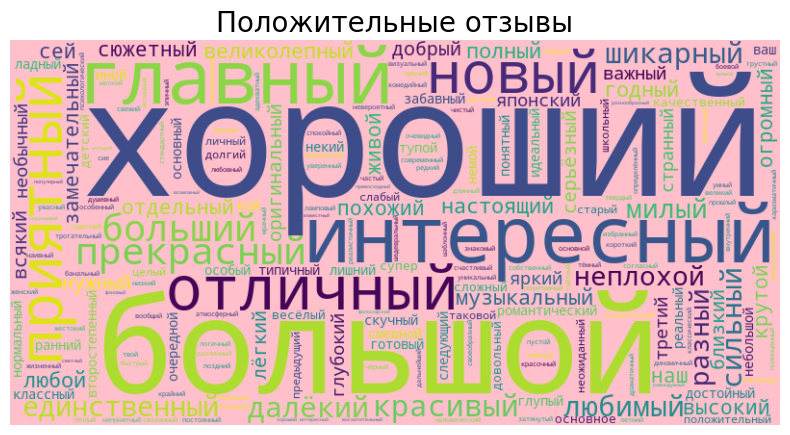

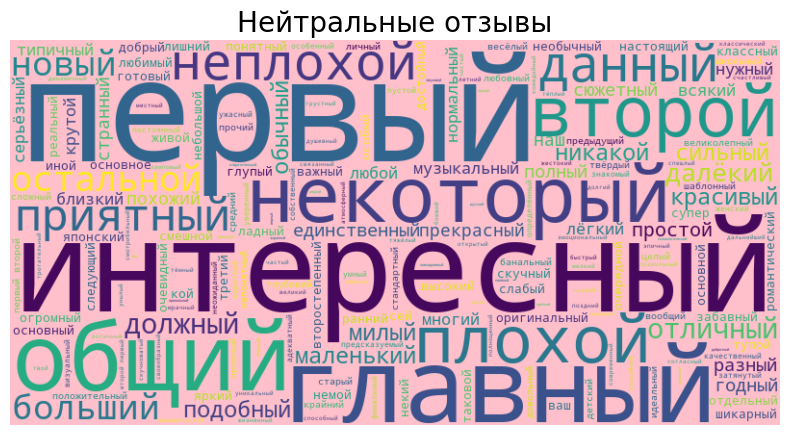

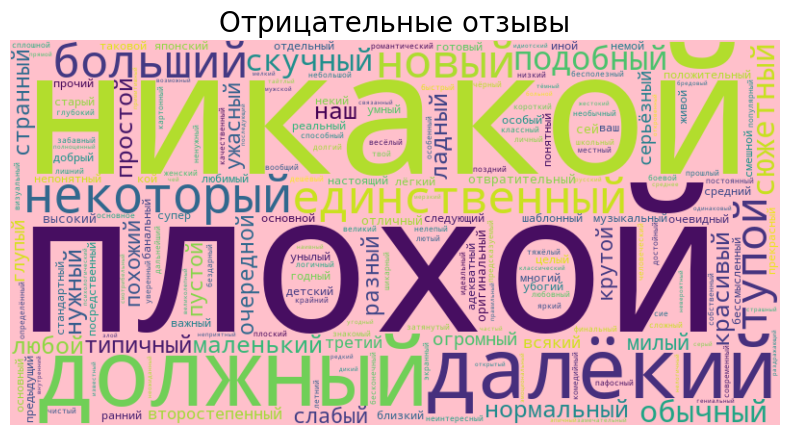

In [431]:
positive = ' '.join(df_final[df_final['Rate'] == 'Положительный']['adjectives'])
positive = remove_from_positive(positive)
neutral = ' '.join(df_final[df_final['Rate'] == 'Нейтральный']['adjectives'])
neutral = remove_from_neutral(neutral)
negative = ' '.join(df_final[df_final['Rate'] == 'Отрицательный']['adjectives'])
negative = remove_from_negative(negative)

plot_wordcloud(positive, 'Положительные отзывы')
plot_wordcloud(neutral, 'Нейтральные отзывы')
plot_wordcloud(negative, 'Отрицательные отзывы')

## Feature Engineering 

**Кодирую категории отзывов и векторизую тексты**

In [433]:
label_encoder = LabelEncoder()
df_final['Rate_Encoded'] = label_encoder.fit_transform(df_final['Rate'])

In [435]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [447]:
vectorizer = TfidfVectorizer(max_features = 7000)
X_text = vectorizer.fit_transform(df_final['Clean_Text'])
X_adjectives = vectorizer.fit_transform(df_final['adjectives'])
X_score_df = df_final[['rating']]

In [448]:
X_combined = hstack([X_text, X_adjectives, X_score_df])

In [451]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, df_final['Rate_Encoded'], test_size=0.2, random_state=42, stratify=df_final['Rate_Encoded']
)

## Random Forest. Подбор гиперпараметров

In [453]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay, 
    precision_score, 
    recall_score, 
    f1_score
)

In [455]:
max_score = 0.5
best_params = {}

n_estimators_list = [100, 200, 500, 1000]
max_depth_list = [None, 10, 20, 30]
min_samples_split_list = [2, 5, 10]
min_samples_leaf_list = [1, 2, 4]

total_iterations = len(n_estimators_list) * len(max_depth_list) * len(min_samples_split_list) * len(min_samples_leaf_list)
progress_bar = tqdm(total=total_iterations, desc="Hyperparameter Tuning")

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for min_samples_split in min_samples_split_list:
            for min_samples_leaf in min_samples_leaf_list:
                model = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    n_jobs=-1,
                    random_state=42
                )
                model.fit(X_train_vecs, y_train)
                preds = model.predict_proba(X_test_vecs)

                score = roc_auc_score(y_test, preds, multi_class='ovr')
                if score > max_score:
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf
                    }
                    max_score = score

                    print(
                        f"New best score: {score} with params: "
                        f"n_estimators={n_estimators}, max_depth={max_depth}, "
                        f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}"
                    )

                progress_bar.update(1)
progress_bar.close()

print(f"Best parameters: {best_params}")
print(f"Best ROC AUC score: {max_score}")

ROC AUC: 0.9644916896714903
               precision    recall  f1-score   support

  Нейтральный       0.86      0.80      0.83      3081
Отрицательный       0.94      0.99      0.97      3081
Положительный       0.84      0.86      0.85      3082

     accuracy                           0.88      9244
    macro avg       0.88      0.88      0.88      9244
 weighted avg       0.88      0.88      0.88      9244



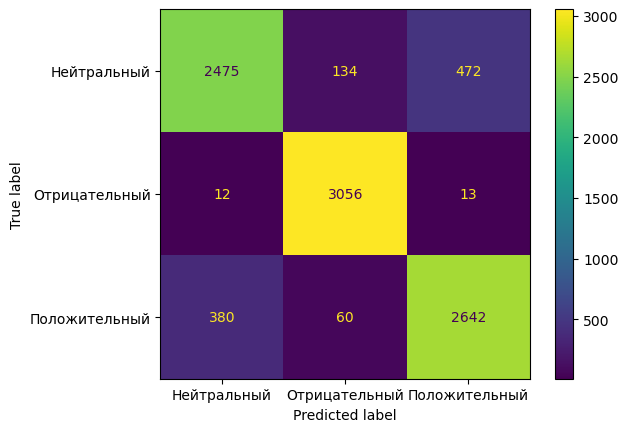

In [465]:
params = {"n_estimators": 200,
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf": 4
    }

rf_model = RandomForestClassifier(
    n_estimators=params['n_estimators'],
    max_depth=params['max_depth'],
    min_samples_split=params['min_samples_split'],
    min_samples_leaf=params['min_samples_leaf'],
    n_jobs=-1,
    random_state=42
)

rf_model .fit(X_train, y_train)

y_pred = rf_model .predict(X_test)
y_pred_proba = rf_model .predict_proba(X_test)

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"ROC AUC: {roc_auc}")

conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot()

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)

## Бустинг для сентимент-анализа и оценка модели

In [471]:
from lightgbm import LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

max_score = 0.5
best_params = {}

n_estimators_list = [100, 200, 500, 1000]
max_depth_list = [3, 4, 5, 6]
learning_rate_list = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
colsample_bytree_list = [0.2, 0.5, 0.75, 1.0]

total_iterations = len(n_estimators_list) * len(max_depth_list) * len(learning_rate_list) * len(colsample_bytree_list)
progress_bar = tqdm(total=total_iterations, desc="Hyperparameter Tuning")

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for learning_rate in learning_rate_list:
            for colsample_bytree in colsample_bytree_list:
                model = LGBMClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                    colsample_bytree=colsample_bytree,
                    n_jobs=-1,
                    verbose=-1
                )
                model.fit(X_train_vecs, y_train)
                preds = model.predict_proba(X_test_vecs)

                score = roc_auc_score(y_test, preds, multi_class='ovr')
                if score > max_score:
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'colsample_bytree': colsample_bytree
                    }
                    max_score = score

                    print(
                        f"New best score: {score} with params: "
                        f"n_estimators={n_estimators}, max_depth={max_depth}, "
                        f"learning_rate={learning_rate}, colsample_bytree={colsample_bytree}"
                    )

                progress_bar.update(1)
progress_bar.close()

print(f"Best parameters: {best_params}")
print(f"Best ROC AUC score: {max_score}")

In [475]:
best_params = {"n_estimators": 1000,
    "max_depth": 4,
    "learning_rate": 0.09,
    "colsample_bytree": 0.2
    }

best_model = LGBMClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    colsample_bytree=best_params['colsample_bytree'],
    n_jobs=-1,
    verbose=-1
)
best_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.2, learning_rate=0.09, max_depth=4,
               n_estimators=1000, n_jobs=-1, verbose=-1)

In [479]:
best_preds = best_model.predict_proba(X_test)
final_score = roc_auc_score(y_test, best_preds, multi_class='ovr')
print(f"Final ROC AUC score: {final_score}")

Final ROC AUC score: 0.9955463080237917


In [483]:
y_pred = best_model.predict(X_test)

precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_micro = f1_score(y_test, y_pred, average='micro')

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print("Микро-усреднение:")
print(f"Precision: {precision_micro:.4f}")
print(f"Recall: {recall_micro:.4f}")
print(f"F1-Score: {f1_micro:.4f}")

print("\nМакро-усреднение:")
print(f"Precision: {precision_macro:.4f}")
print(f"Recall: {recall_macro:.4f}")
print(f"F1-Score: {f1_macro:.4f}")

print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Микро-усреднение:
Precision: 0.9494
Recall: 0.9494
F1-Score: 0.9494

Макро-усреднение:
Precision: 0.9495
Recall: 0.9494
F1-Score: 0.9494

Отчет по классификации:
               precision    recall  f1-score   support

  Нейтральный       0.92      0.93      0.92      3081
Отрицательный       1.00      1.00      1.00      3081
Положительный       0.93      0.92      0.93      3082

     accuracy                           0.95      9244
    macro avg       0.95      0.95      0.95      9244
 weighted avg       0.95      0.95      0.95      9244

